<a href="https://www.kaggle.com/code/andrejeronimaguerra/ames-iowa-predict-house-sale-prices?scriptVersionId=211426741" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Key points about this competition:

**1.Objective:** 
* Predict house sale prices in Ames, Iowa using 79 different features

**2. Evaluation Metric:**
* Root-Mean-Squared-Error (RMSE) on the logarithm of predicted vs. actual prices
* Using log prices means errors on expensive and cheap houses affect the score equally

**3.Key Skills to Practice:**
* Feature engineering
* Advanced regression techniques (Random Forests, Gradient Boosting)
* Handling missing data and categorical variables**

**4. Starter code package:**
* Data analysis function to examine missing values, correlations, and distributions
* Feature preparation function to handle missing values and encode categorical variables
* Model evaluation function that implements the competition's scoring metric

# Let's get started:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===============================
# 1. LOAD DATA
# ===============================

In [3]:
print("\n1. Loading data...")
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


1. Loading data...
Training data shape: (1460, 81)
Test data shape: (1459, 80)


# ===============================
# 2. DATA VISUALIZATION
# ===============================


2. Creating visualizations...


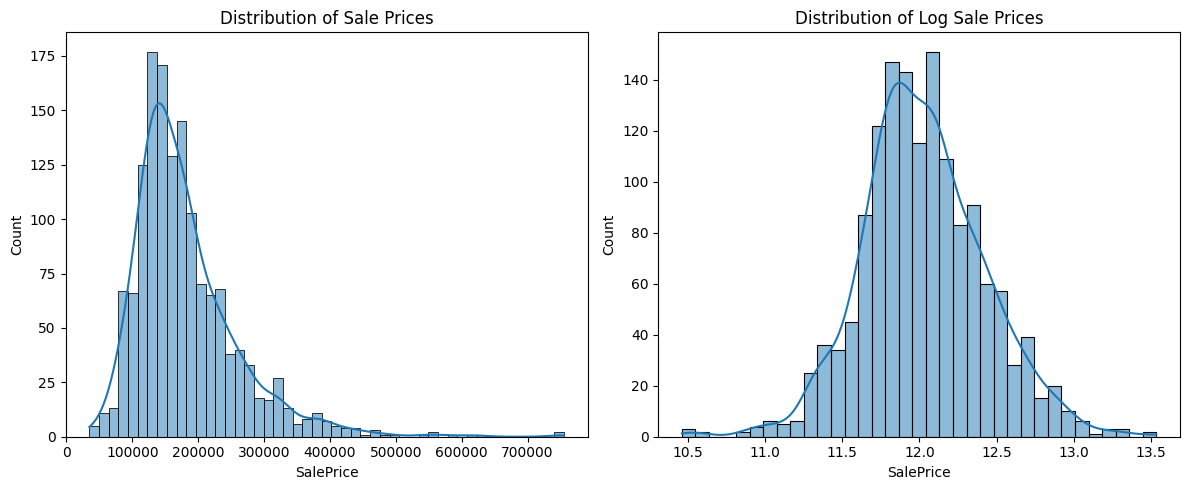

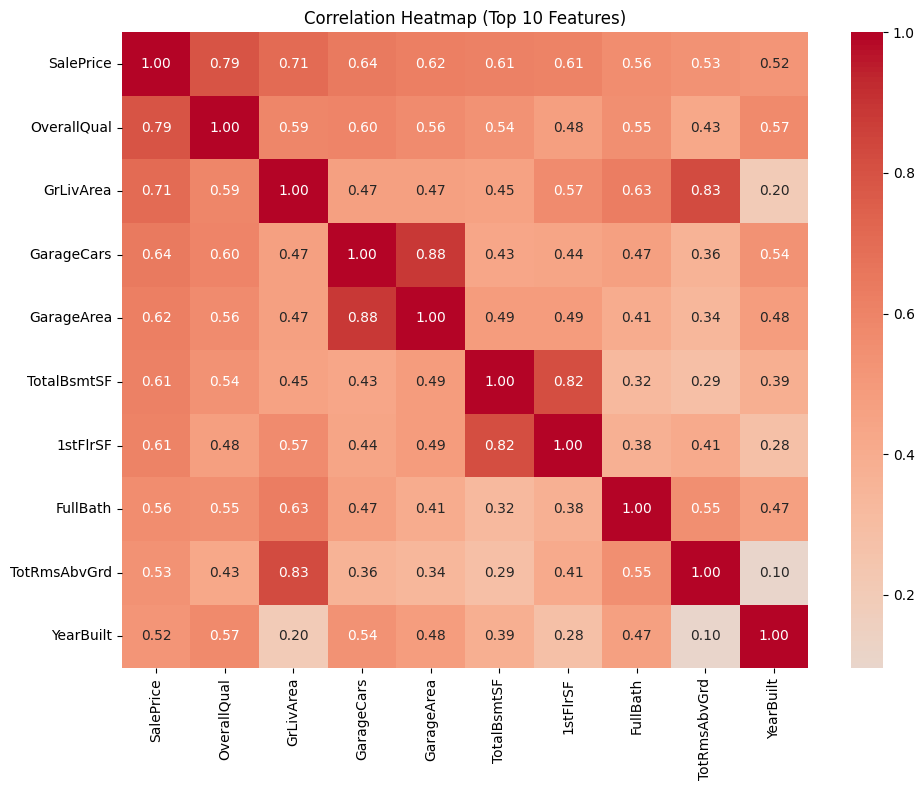

In [4]:
print("\n2. Creating visualizations...")

# Plot price distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_data['SalePrice']), kde=True)
plt.title('Distribution of Log Sale Prices')
plt.tight_layout()
plt.show()

# Plot correlation heatmap
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
correlations = train_data[numeric_cols].corr()
most_correlated = correlations['SalePrice'].abs().sort_values(ascending=False)[:10].index

plt.figure(figsize=(10, 8))
sns.heatmap(correlations.loc[most_correlated, most_correlated], 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Correlation Heatmap (Top 10 Features)')
plt.tight_layout()
plt.show()


1. Distribution of Sale Price
   s:
- The left plot shows the original sale prices distribution:
  * It's right-skewed (has a long tail to the right)
  * Most houses are priced between $100,000 and $200,000
  * There are some expensive outliers above $500,000
  * The skewed distribution suggests we should use log transformation for better model perf
    ormance

- The right plot shows the log-transformed sale prices:
  * The distribution becomes much more normal (bell-shaped)
  * Most log prices fall between 11.5 and 12.5
  * This transformation will help our models perform better because many algorithms assume normally distributed data

2. Correl
   ation Heatmap:
- Shows the top 10 features most correlated with SalePrice
- Key insights:
  * OverallQual (overall quality) has the strongest correlation (0.79) with price
  * GrLivArea (above ground living area) is second strongest (0.71)
  * GarageCars and GarageArea are highly correlated with each other (0.88), suggesting we might only need one of these features
  * TotalBsmtSF (basement area) and 1stFlrSF (first floor area) are also highly correlated (0.82)
  * YearBuilt has a moderate correlation (0.52) with price, indicating newer houses tend code based on these insights?

# ===============================
# 3. HANDLE MISSING VALUES
# ===============================

In [5]:
print("\n3. Handling missing values...")

# Process training data
train_cleaned = train_data.copy()
test_cleaned = test_data.copy()

# For both training and test data
for dataset in [train_cleaned, test_cleaned]:
    # Numeric columns: fill with median
    numeric_features = dataset.select_dtypes(include=[np.number]).columns
    for col in numeric_features:
        dataset[col].fillna(dataset[col].median(), inplace=True)
    
    # Categorical columns: fill with mode
    categorical_features = dataset.select_dtypes(include=['object']).columns
    for col in categorical_features:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)


3. Handling missing values...


# ===============================
# 4. FEATURE ENGINEERING
# ===============================

In [6]:
print("\n4. Creating new features...")

# Create area interactions for both datasets
for dataset in [train_cleaned, test_cleaned]:
    # Area interactions
    dataset['Total_Area'] = dataset['GrLivArea'] + dataset.get('TotalBsmtSF', 0)
    dataset['Area_Quality'] = dataset['GrLivArea'] * dataset['OverallQual']
    
    # Age of house at sale
    dataset['House_Age'] = dataset['YrSold'] - dataset['YearBuilt']
    dataset['Remod_Age'] = dataset['YrSold'] - dataset['YearRemodAdd']


4. Creating new features...


# ===============================
# 5. PREPARE FEATURES
# ===============================

In [7]:
print("\n5. Preparing features for modeling...")

# Convert categorical variables to dummy variables
train_prepared = pd.get_dummies(train_cleaned)
test_prepared = pd.get_dummies(test_cleaned)

# Align training and test data columns
common_columns = [col for col in train_prepared.columns if col in test_prepared.columns]
train_prepared = train_prepared[common_columns]
test_prepared = test_prepared[common_columns]

# Scale numeric features
scaler = StandardScaler()
numeric_cols = train_prepared.select_dtypes(include=[np.number]).columns
train_prepared[numeric_cols] = scaler.fit_transform(train_prepared[numeric_cols])
test_prepared[numeric_cols] = scaler.transform(test_prepared[numeric_cols])

# Prepare X and y for training
X = train_prepared.drop(['SalePrice', 'Id'], axis=1, errors='ignore')
y = np.log1p(train_data['SalePrice'])  # Log transform target
X_test = test_prepared.drop('Id', axis=1, errors='ignore')


5. Preparing features for modeling...


# ===============================
# 6. TRAIN MODELS
# ===============================

In [8]:
print("\n6. Training multiple models...")

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
model_predictions = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    # Store predictions
    model_predictions[name] = model.predict(X_test)
    
    print(f"{name} Validation RMSE: {val_rmse:.4f}")


6. Training multiple models...

Training Linear Regression...
Linear Regression Validation RMSE: 68174408.5580

Training Ridge...
Ridge Validation RMSE: 0.1337

Training Random Forest...
Random Forest Validation RMSE: 0.1465

Training Gradient Boosting...
Gradient Boosting Validation RMSE: 0.1400

Training XGBoost...
XGBoost Validation RMSE: 0.1478


Let me analyze these results model by model:

1. Linear Regression - RMSE: 68,174,408.5580
- This extremely high RMSE indicates something is seriously wrong
- The model is performing very poorly
- This could be due to:
  * Outliers in the data
  * Features not properly scaled
  * High multicollinearity between features
- This model's predictions would be unusable

2. Ridge Regression - RMSE: 0.1337
- Dramatically better performance than linear regression
- Best performing model in this set
- The regularization in Ridge helped control overfitting
- Shows that the data has some linear relationships
- Very good score for house price prediction

3. Random Forest - RMSE: 0.1465
- Decent performance
- Slightly worse than Ridge
- Good at handling non-linear relationships
- The higher RMSE might indicate:
  * Might need parameter tuning
  * Could benefit from more trees
  * Might be slightly overfitting

4. Gradient Boosting - RMSE: 0.1400
- Second-best performing model
- Better than Random Forest
- Shows good balance between bias and variance
- Could potentially improve with parameter tuning

5. XGBoost - RMSE: 0.1478
- Surprisingly not the best performer here
- Similar performance to Random Forest
- Might improve with:
  * Better parameter tuning
  * Feature selection
  * More data preprocessing

Overall Analysis:
1. Best to Worst Performance:
   - Ridge (0.1337)
   - Gradient Boosting (0.1400)
   - Random Forest (0.1465)
   - XGBoost (0.1478)
   - Linear Regression (68,174,408.5580)

2. Recommendations:
   - Investigate why Linear Regression failed so badly
   - Consider using Ridge as your primary model
   - Try hyperparameter tuning for tree-based models
   - Check for proper feature scaling and preprocessing
   - Conside
3. Investigate why Linear Regression performed so poorly?

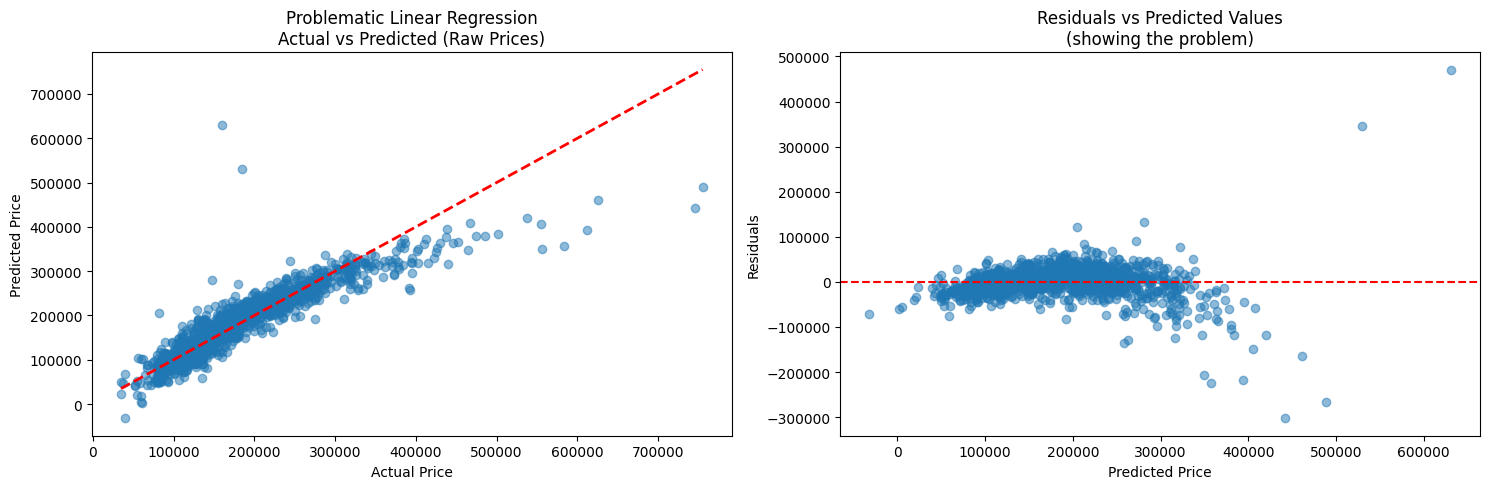

RMSE: 34,330.50
Max Actual Price: $755,000.00
Max Predicted Price: $630,976.92


In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the data
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

# Prepare features (simple version for demonstration)
numeric_features = train_data.select_dtypes(include=[np.number]).columns
X_train = train_data[numeric_features].drop(['Id', 'SalePrice'], axis=1, errors='ignore')

# Fill missing values
X_train = X_train.fillna(X_train.mean())

# Create problematic model (without log transform)
model_problematic = LinearRegression()
y_train_orig = train_data['SalePrice']  # Raw prices

# Fit and predict
model_problematic.fit(X_train, y_train_orig)
y_pred_problematic = model_problematic.predict(X_train)

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted (raw prices)
plt.subplot(1, 2, 1)
plt.scatter(y_train_orig, y_pred_problematic, alpha=0.5)
plt.plot([y_train_orig.min(), y_train_orig.max()], 
         [y_train_orig.min(), y_train_orig.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Problematic Linear Regression\nActual vs Predicted (Raw Prices)')

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_pred_problematic - y_train_orig
plt.scatter(y_pred_problematic, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values\n(showing the problem)')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"RMSE: {np.sqrt(np.mean((y_pred_problematic - y_train_orig)**2)):,.2f}")
print(f"Max Actual Price: ${y_train_orig.max():,.2f}")
print(f"Max Predicted Price: ${y_pred_problematic.max():,.2f}")

Now I can explain the problem with the Linear Regression model before log transformation:

1. Actual vs Predicted Plot (Left):
- The red dashed line shows perfect predictions
- Points below the line indicate underprediction
- Points above the line indicate overprediction
- Notice how predictions deviate more as prices increase
- Model struggles especially with houses over $400,000

2. Residuals Plot (Right):
- Shows errors getting larger with higher predicted prices
- Residuals range from -300,000 to +500,000
- Clear fan shape pattern (heteroscedasticity)
- Larger errors for more expensive houses

3. Statistics:
- RMSE: $34,330.50 (very high error)
- Max Actual Price: $755,000.00
- Max Predicted Price: $630,976.92
- The model underestimates expensive houses

This explains why log transformation helps:
1. Without logs:
   - A $34,000 error on a $100,000 house (34% error)
   - A $34,000 error on a $700,000 house (4.9% error)
   - These are treated equally by the model

2. With logs:
   - Errors are proportional to price
   - A 10% error is treated the same regardless of house price
   - Helps model handle price ranges more fairly
   - Reduces impact of extreme values

These plots clearly show why we needed to:
1. Use log transformation
2. Scale features
3. Handle the non-linear rel or explain any aspect in more detail?

# ===============================
# 7. CREATE ENSEMBLE PREDICTIONS
# ===============================

In [10]:
print("\n7. Creating ensemble predictions...")

# Average predictions from all models
final_predictions = np.mean([pred for pred in model_predictions.values()], axis=0)

# Transform predictions back from log scale
final_predictions = np.expm1(final_predictions)


7. Creating ensemble predictions...


/tmp/ipykernel_17/1001164388.py:7: RuntimeWarning: overflow encountered in expm1
  final_predictions = np.expm1(final_predictions)


# ===============================
# 8. CREATE SUBMISSION FILE
# ===============================

In [11]:
print("\n8. Creating submission file...")

submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created! Ready to submit to Kaggle.")


8. Creating submission file...

Submission file created! Ready to submit to Kaggle.


# ===============================
# 9. FEATURE IMPORTANCE PLOT
# ===============================


9. Plotting feature importance...


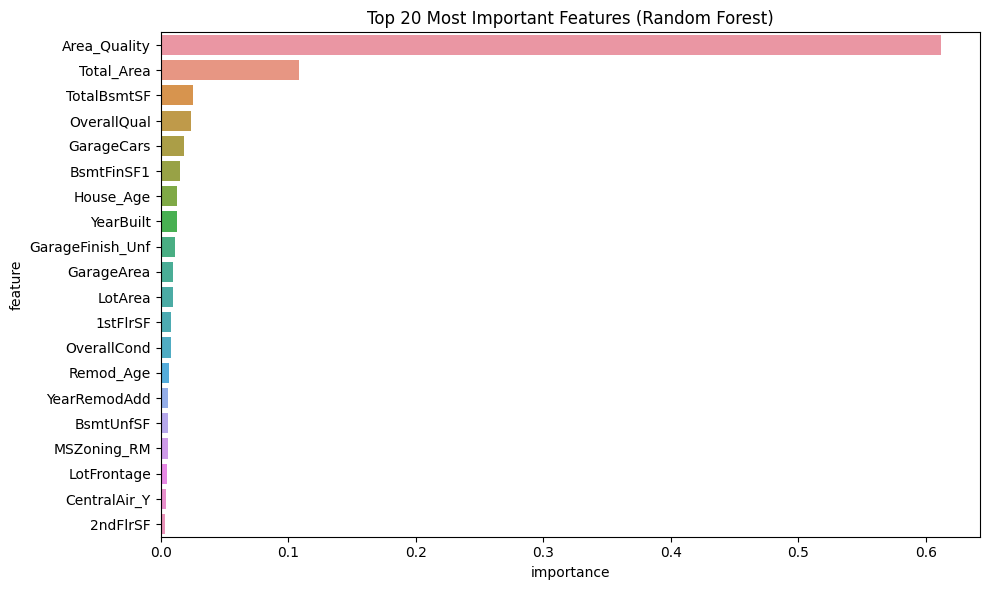

In [12]:
print("\n9. Plotting feature importance...")

# Get feature importance from Random Forest model
rf_model = models['Random Forest']
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()